In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plot_settings
import matplotlib as mpl
import networkx as nx
import matplotlib.ticker as tk
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']= 'STIXGeneral'
mpl.rcParams['mathtext.fontset']= 'stix'
mpl.rcParams['font.size']= 24

def read_gset(path: str):
    with open(path) as infile:
        G = nx.Graph()
        edges = []
        offset = 0 if '.gset' in path else 1
        nodes, n_edges = map(int, infile.readline().strip().split())
        const = 0
        J = np.zeros((nodes, nodes))
        for line in infile:
            args = line.strip().split()
            u, v = map(int, args[:2])
            edges.append((u-offset, v-offset))
        G.add_nodes_from(range(nodes))
        G.add_edges_from(edges)
        return G


In [2]:
import re
from scipy.stats import pmean
def get_mean_eigvalue(gname: str):
    G = read_gset(f'../gset_benchmarks/{gname}')
    A = nx.adjacency_matrix(G).toarray()
    eigvals = np.linalg.eigvalsh(A)
    return np.mean(np.abs(eigvals)), pmean(np.abs(eigvals), 2), np.max(np.abs(eigvals))
ttt_df = pd.concat([ pd.read_csv('../data/bw_vs_energy_ttt98.csv').query('concurrent==1'), pd.read_csv('../data/bw_vs_energy_longer_ttt.csv')]).reset_index()
eig_data = []
for g in ttt_df['graph'].unique():
    gind = int(re.findall(r'G(\d+)', g)[0])
    eig_data.append((g, *get_mean_eigvalue(g), 'BA' if gind > 35 else 'ER'))
eig_df = pd.DataFrame(eig_data, columns=['graph', 'eigmean', 'eigpmean2', 'eigmax', 'type'])

In [3]:
idir = '../data'

def make_tts_df(df: pd.DataFrame, cols=[], groupcols=[], 
                targets=[0.9999999, 0.995], 
                metrics=[('TTT', 'anneal')], 
                sort_metric='TTT'):
    dataframes = []
    for targ in targets:
        df[f'GS'] = df['Ratio'] >= targ
        mean_df = df.groupby(['graph'] + cols + groupcols).mean(numeric_only=True).reset_index()
        mean_df['target'] = targ
        mean_df['factor'] = 1
        badind = (mean_df[f'GS'] < 0.99) & (mean_df[f'GS'] > 1e-10)
        prob = np.array(mean_df.loc[badind][f'GS'])
        mean_df.loc[badind, 'factor'] = np.log10(0.01) / np.log10(1-prob)
        for field, metric in metrics:
            mean_df[f'{field}'] =  mean_df[metric]
            metarr =  np.array(mean_df.loc[badind][metric])
            mean_df.loc[badind, f'{field}'] = metarr * mean_df.loc[badind, 'factor']
            mean_df.loc[(mean_df[f'GS'] <= 1e-10), f'{field}'] = np.inf
            tts_df = mean_df.sort_values(by=sort_metric).drop_duplicates(
                ['graph', 'target']
+cols)
            dataframes.append(tts_df)
    return pd.concat(dataframes)


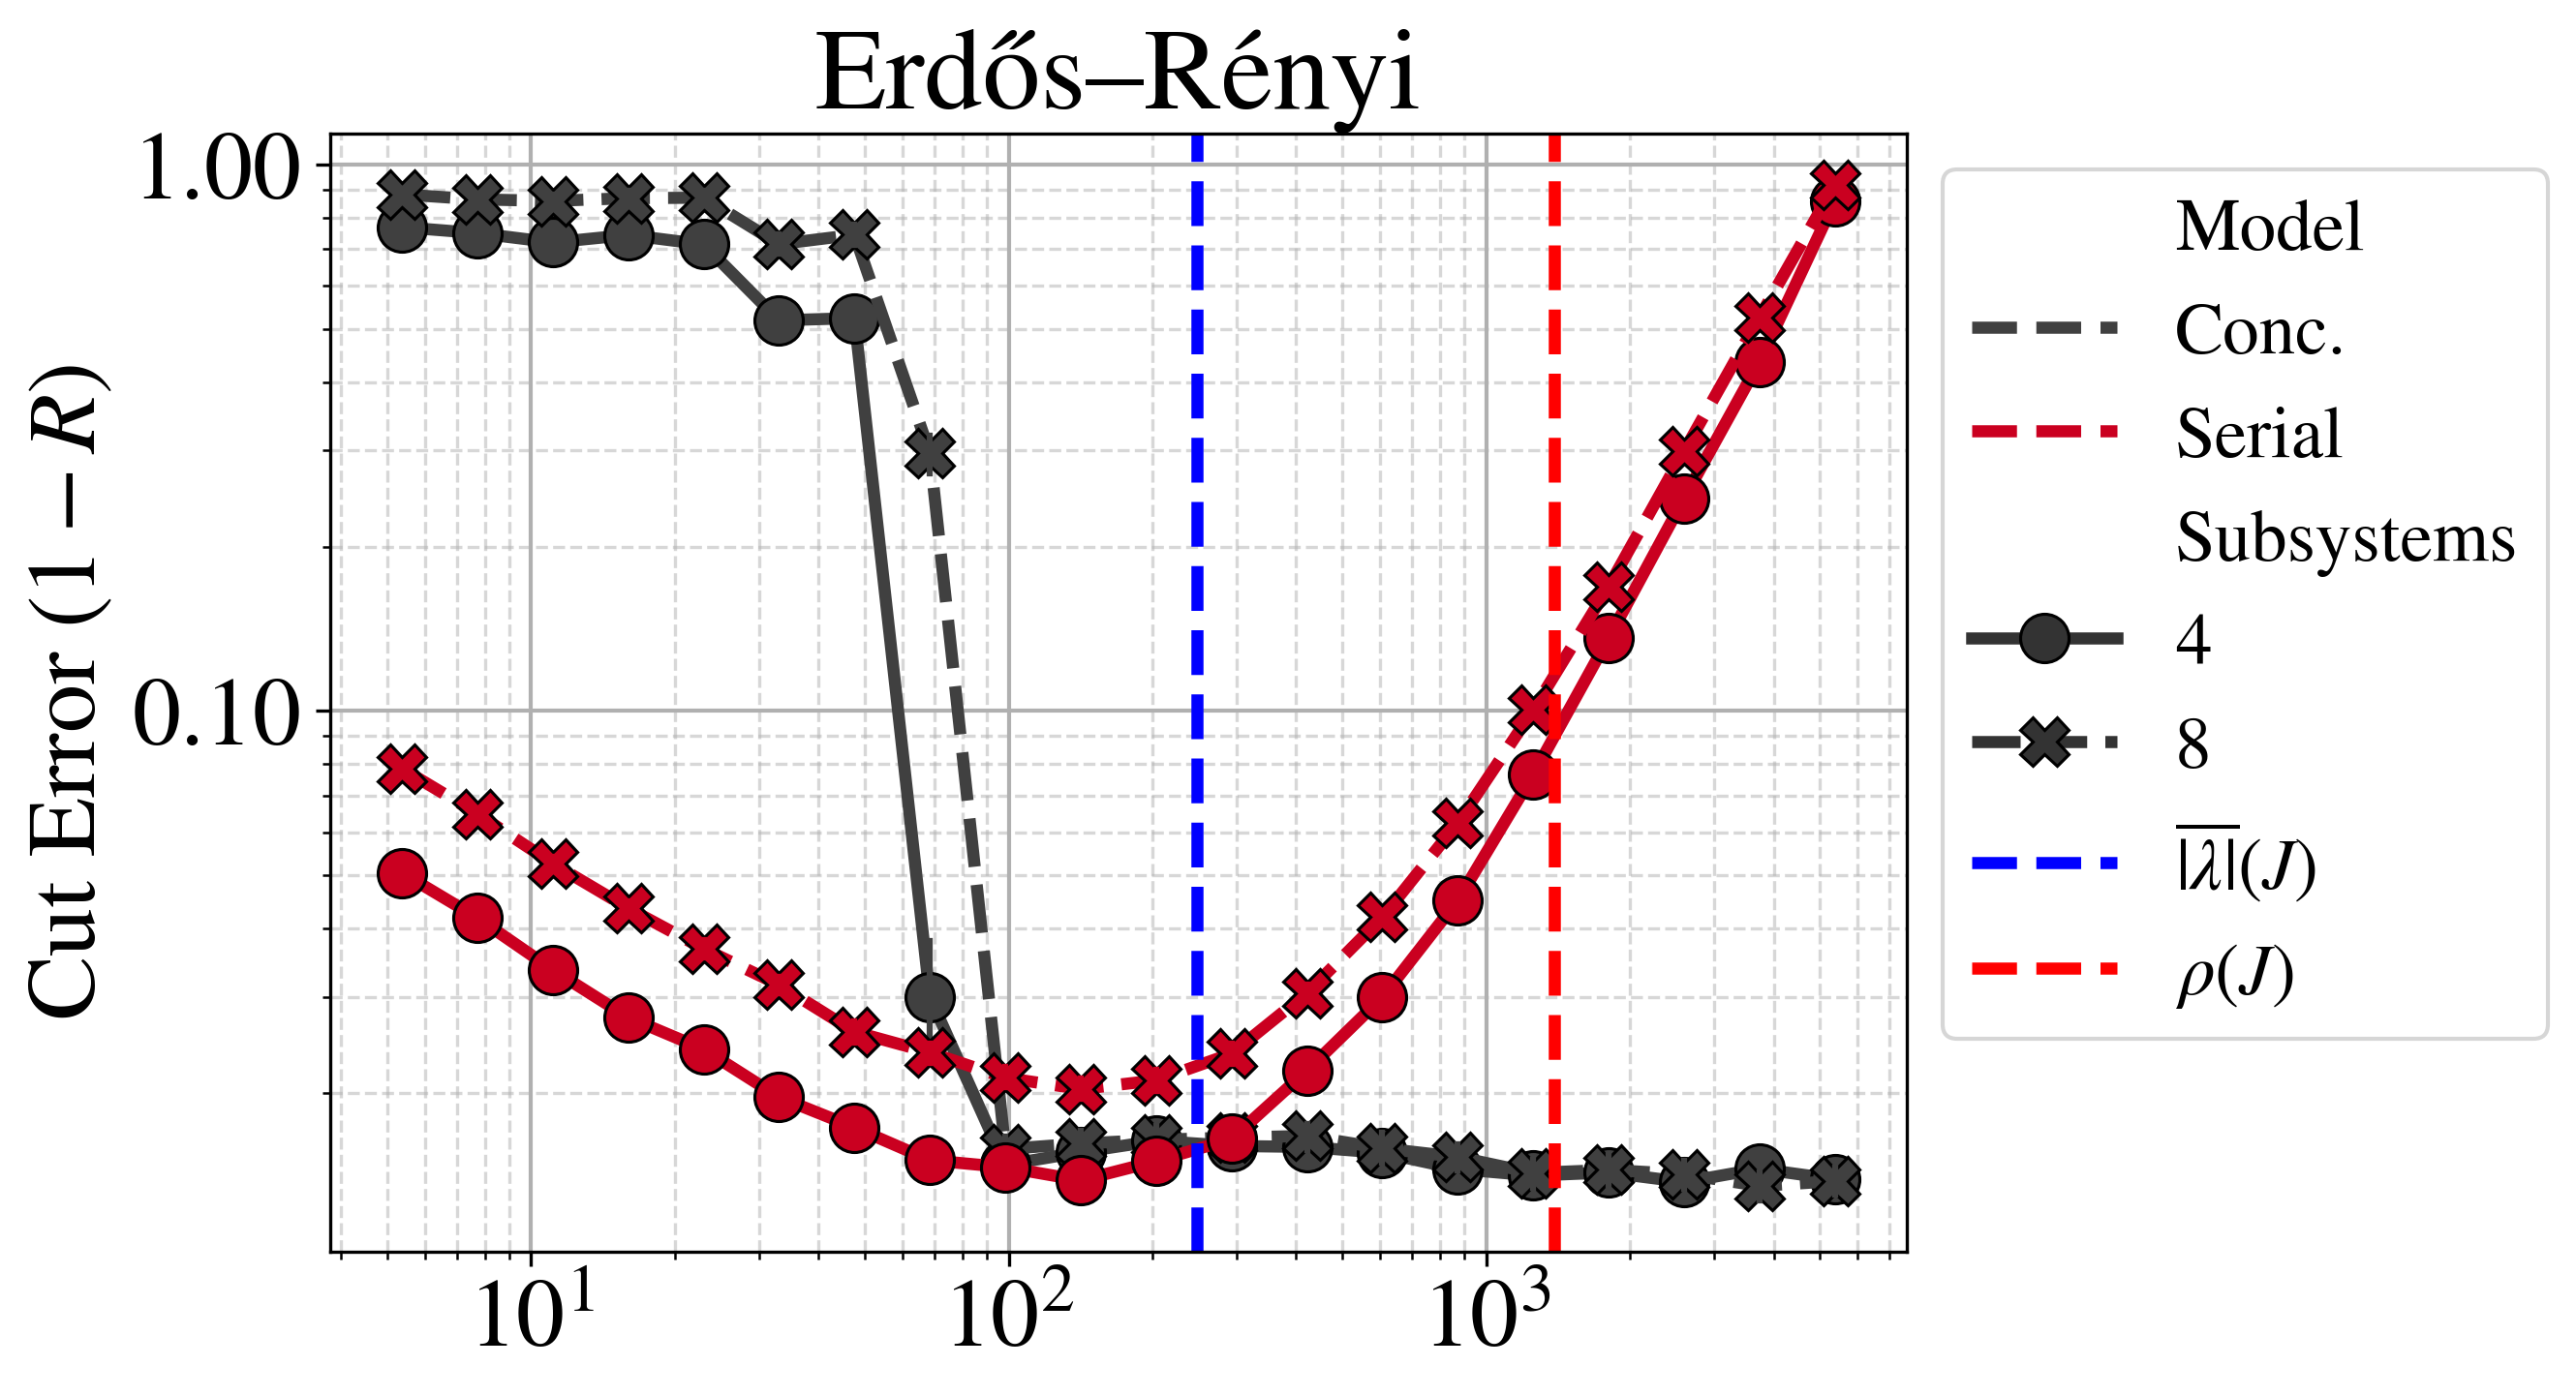

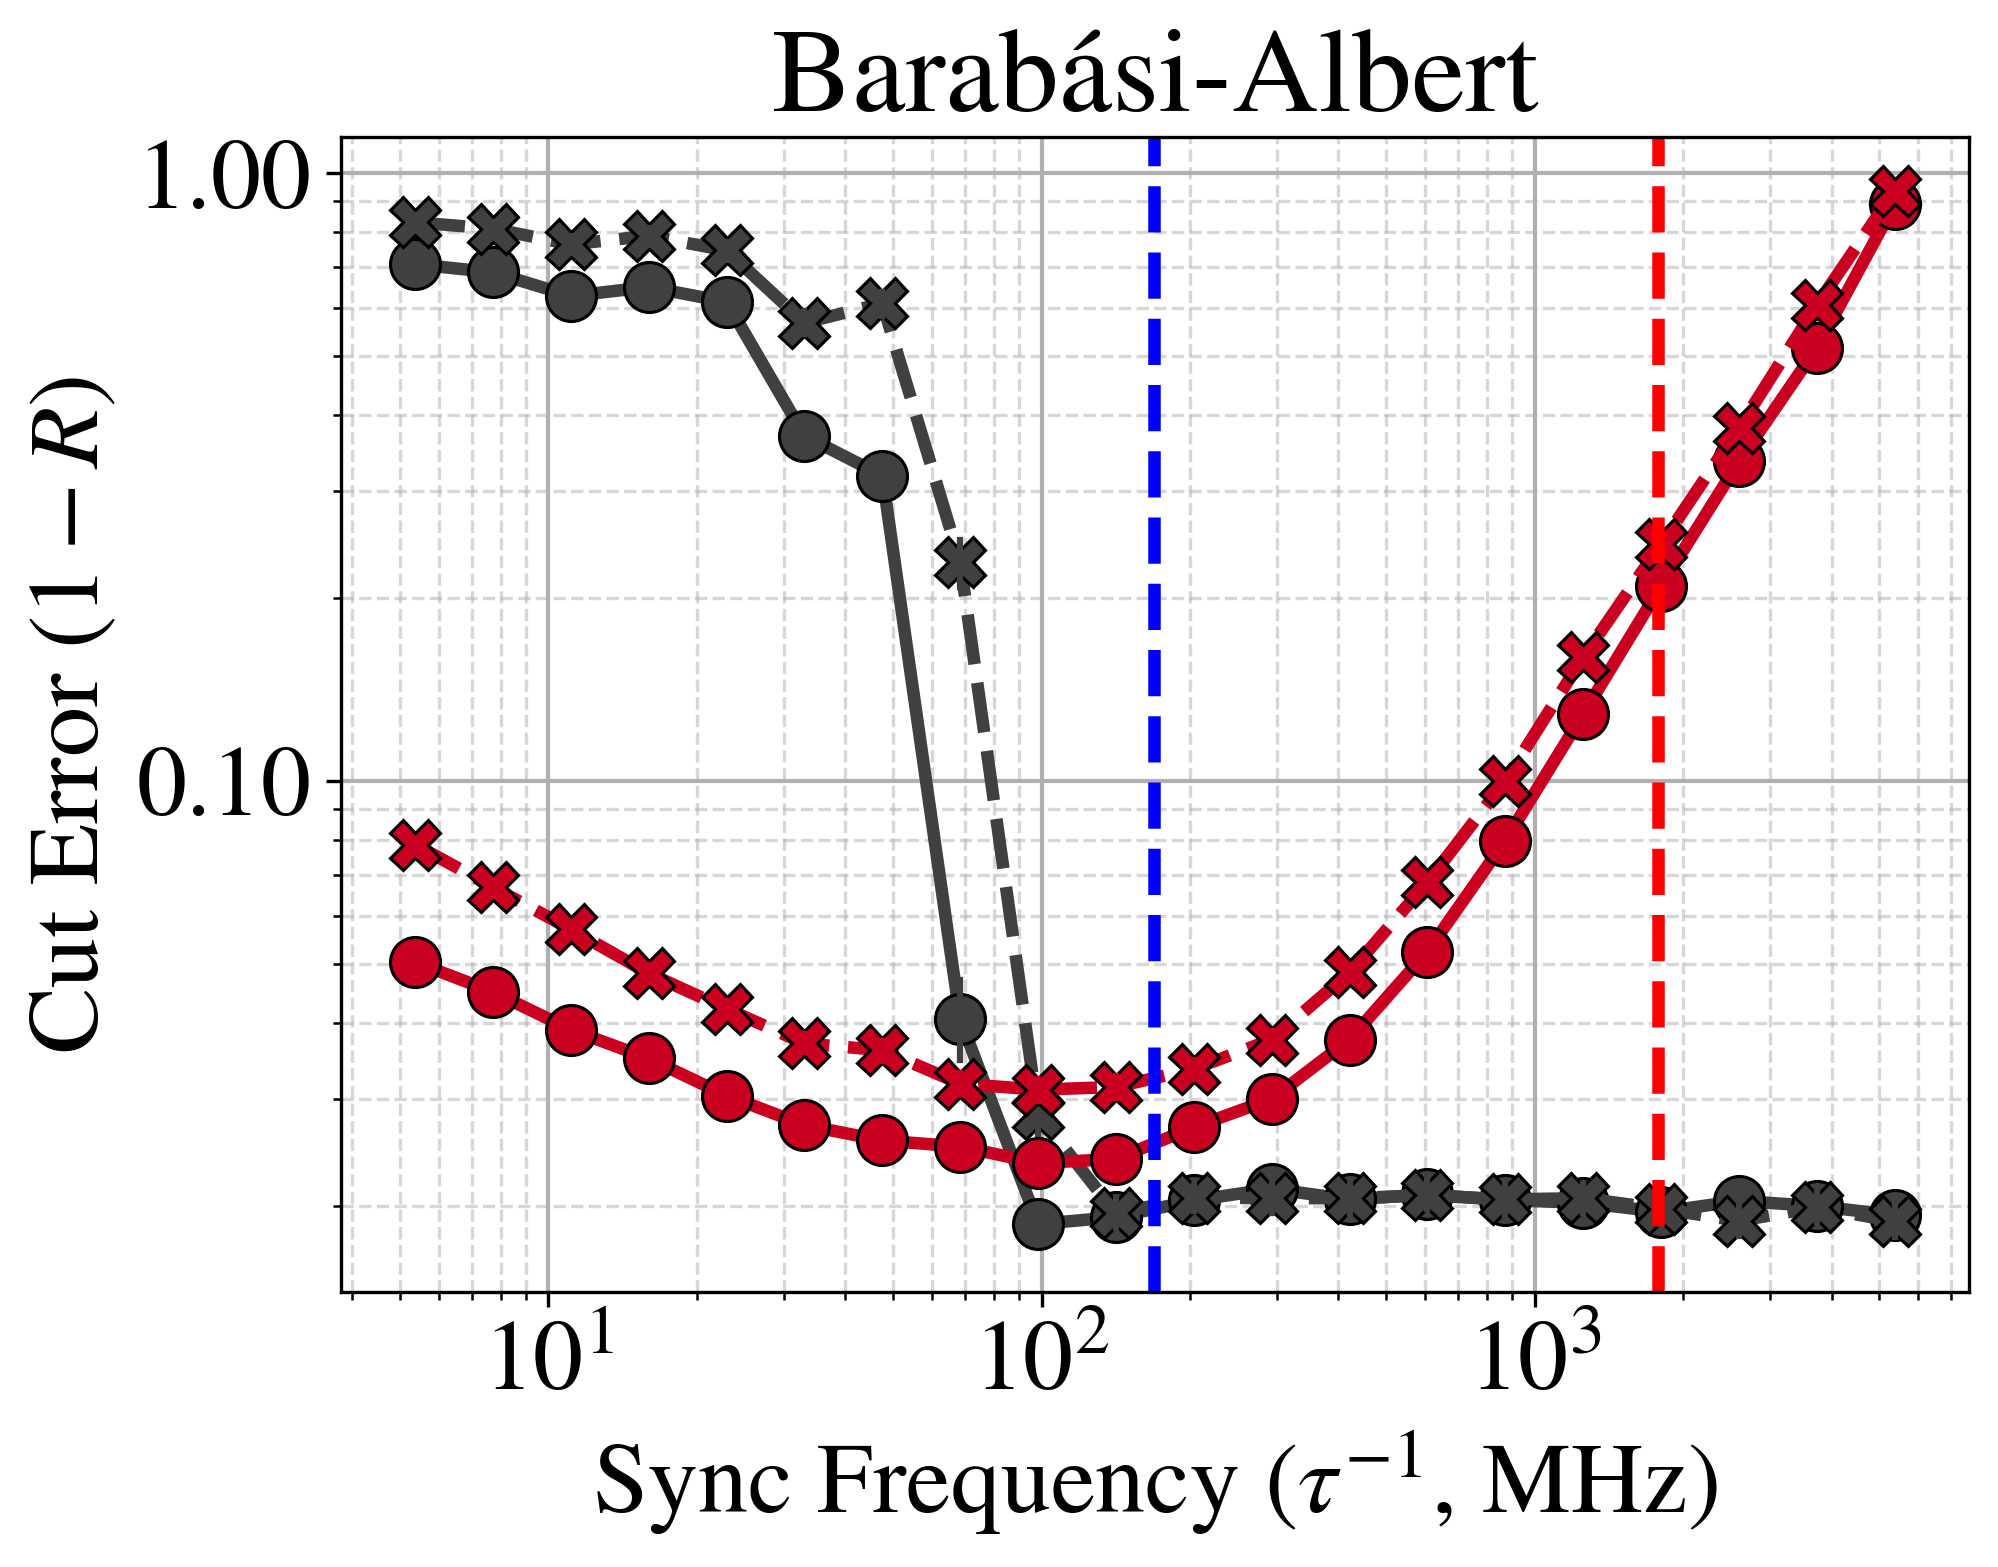

In [8]:
fig1, ax = plt.subplots(figsize=(7, 5))
fig2, ax2 = plt.subplots(figsize=(7, 5))
axs = [ax, ax2]
brim_df = pd.read_csv('../data/bw_vs_energy_full.csv').rename(columns={'blocks': 'Subsystems'})
brim_df['Model'] = brim_df['concurrent'].replace({True: 'Conc.', False: 'Serial'})
palette = [ "#404040",
            # "#fdb863",
            # "#f4a582",
            "#ca0020"
            ]
brim_df = brim_df.merge(eig_df, on='graph')
brim_df['Bandwidth'] = 1 / brim_df['tpart'] / 1e6
# brim_df['error'] = brim_df['u'] - -0.7633
line_args = dict(
    y='Inverse Ratio',
    x='Bandwidth',
    linestyle='--',
    # marker='X',
    markers=True,
    markersize=12,
    style='Subsystems',
    linewidth=3,
    hue='Model',
    markeredgecolor='black',
    err_style='bars',
    palette=palette
)
sns.lineplot(ax=axs[0],
                data=brim_df.query('GInd < 30'), 
                **line_args)
sns.lineplot(ax=axs[1],
                data=brim_df.query('GInd > 30'), 
                **line_args)
eig1 = (49e-15 * 31e4) / eig_df.query('type == "ER"')['eigmean'].mean()
axs[0].axvline(1/eig1 / 1e6, color='blue', linewidth=3, linestyle='--', label='$\\overline{|\\lambda|}(J)$')
eig2 = (49e-15 * 31e4) / eig_df.query('type == "BA"')['eigmean'].mean()
axs[1].axvline(1/eig2 / 1e6, color='blue', linewidth=3, linestyle='--')
eig1 = (49e-15 * 31e4) / eig_df.query('type == "ER"')['eigmax'].mean()
axs[0].axvline(1/eig1 / 1e6, color='red', linewidth=3, linestyle='--', label='$\\rho(J)$')
eig2 = (49e-15 * 31e4) / eig_df.query('type == "BA"')['eigmax'].mean()
axs[1].axvline(1/eig2 / 1e6, color='red', linewidth=3, linestyle='--')
axs[0].legend(fontsize=18, loc='upper left', bbox_to_anchor=(1,1))

axs[0].set_title('Erdős–Rényi')
axs[1].set_title('Barabási-Albert')
axs[0].set_xlabel('')
axs[1].set_xlabel('Sync Frequency ($\\tau^{-1}$, MHz)')
for ax in axs:
   ax.set_xscale('log')
   ax.set_yscale('log')
#    ax.set_xlabel('Sync Frequency ($\\tau^{-1}$, MHz)')
   ax.set_ylabel('Cut Error ($1-R$)')
   ax.grid(which='major')
axs[1].legend_.set_visible(False)

for ax in axs:

    ax.grid(which='minor', linestyle='--', alpha=0.5)
    ax.grid(which='major', linewidth=1)
    ax.yaxis.set_major_locator(tk.LogLocator(base=10, subs=[1]))
    ax.yaxis.set_minor_locator(tk.LogLocator(base=10, subs=[1,2,3,4,5,6,7,8,9]))
    ax.xaxis.set_major_locator(tk.LogLocator(base=10, subs=[1]))
    ax.xaxis.set_minor_locator(tk.LogLocator(base=10, subs=[1,2,3,4,5,6,7,8,9]))
    # ax.yaxis.set_minor_locator(tk.FixedLocator([50, 150, 200]))
    ax.yaxis.set_major_formatter(tk.ScalarFormatter())
    # ax.yaxis.set_minor_formatter(tk.ScalarFormatter())

# axs[0].annotate(text="(a)", xy=(0.45, -0.15), xycoords='axes fraction', fontsize=28)

# axs[1].annotate(text="(b)", xy=(0.45, -0.3), xycoords='axes fraction', fontsize=28)
plt.show()
fig1.savefig('../figures/fig_8a_ba_er_cut_error.pdf', bbox_inches='tight')
fig2.savefig('../figures/fig_8b_ba_er_cut_error.pdf', bbox_inches='tight')
# axs[]

In [10]:
fill_df_serial = brim_df.query('`Inverse Ratio` <= 0.02')
fill_df_serial=fill_df_serial.groupby(['Type', 'Model', 'Subsystems']).agg({'Bandwidth': ['min', 'max']}).reset_index()
# fig, ax = plt.subplots()
# lim1 = fill_df_serial.loc[(fill_df_serial['Type'] == 'ER') & (fill_df_serial['Model'] == "Conc.")]
# ax.barh(y=[-0.2,0.4], width=lim1[('Bandwidth', 'max')], height=0.2,  left=lim1[('Bandwidth', 'min')])
# lim1 = fill_df_serial.loc[(fill_df_serial['Type'] == 'ER') & (fill_df_serial['Model'] == "Serial")]
# ax.barh(y=[0.02,0.62], width=lim1[('Bandwidth', 'max')], height=0.2,  left=lim1[('Bandwidth', 'min')])
# ax.set_yticks([-0.11, 0.51])
# ax.set_xscale('log')
# ax.set_xlim(axs[1].get_xlim())
# ax.set_yticklabels(['4', '8'])

# fig, ax = plt.subplots()
lim_er4 = fill_df_serial.loc[(fill_df_serial['Type'] == 'ER') & (fill_df_serial['Model'] == "Serial") & (fill_df_serial['Subsystems'] == 4)]
lim_ba4 = fill_df_serial.loc[(fill_df_serial['Type'] == 'BA') & (fill_df_serial['Model'] == "Serial") & (fill_df_serial['Subsystems'] == 4)]
lim_er8 = fill_df_serial.loc[(fill_df_serial['Type'] == 'ER') & (fill_df_serial['Model'] == "Serial") & (fill_df_serial['Subsystems'] == 8)]
lim_ba8 = fill_df_serial.loc[(fill_df_serial['Type'] == 'BA') & (fill_df_serial['Model'] == "Serial") & (fill_df_serial['Subsystems'] == 8)]

# ax.set_xlim(axs[1].get_xlim())
# brim_df[['Model', 'Inverse Ratio']]

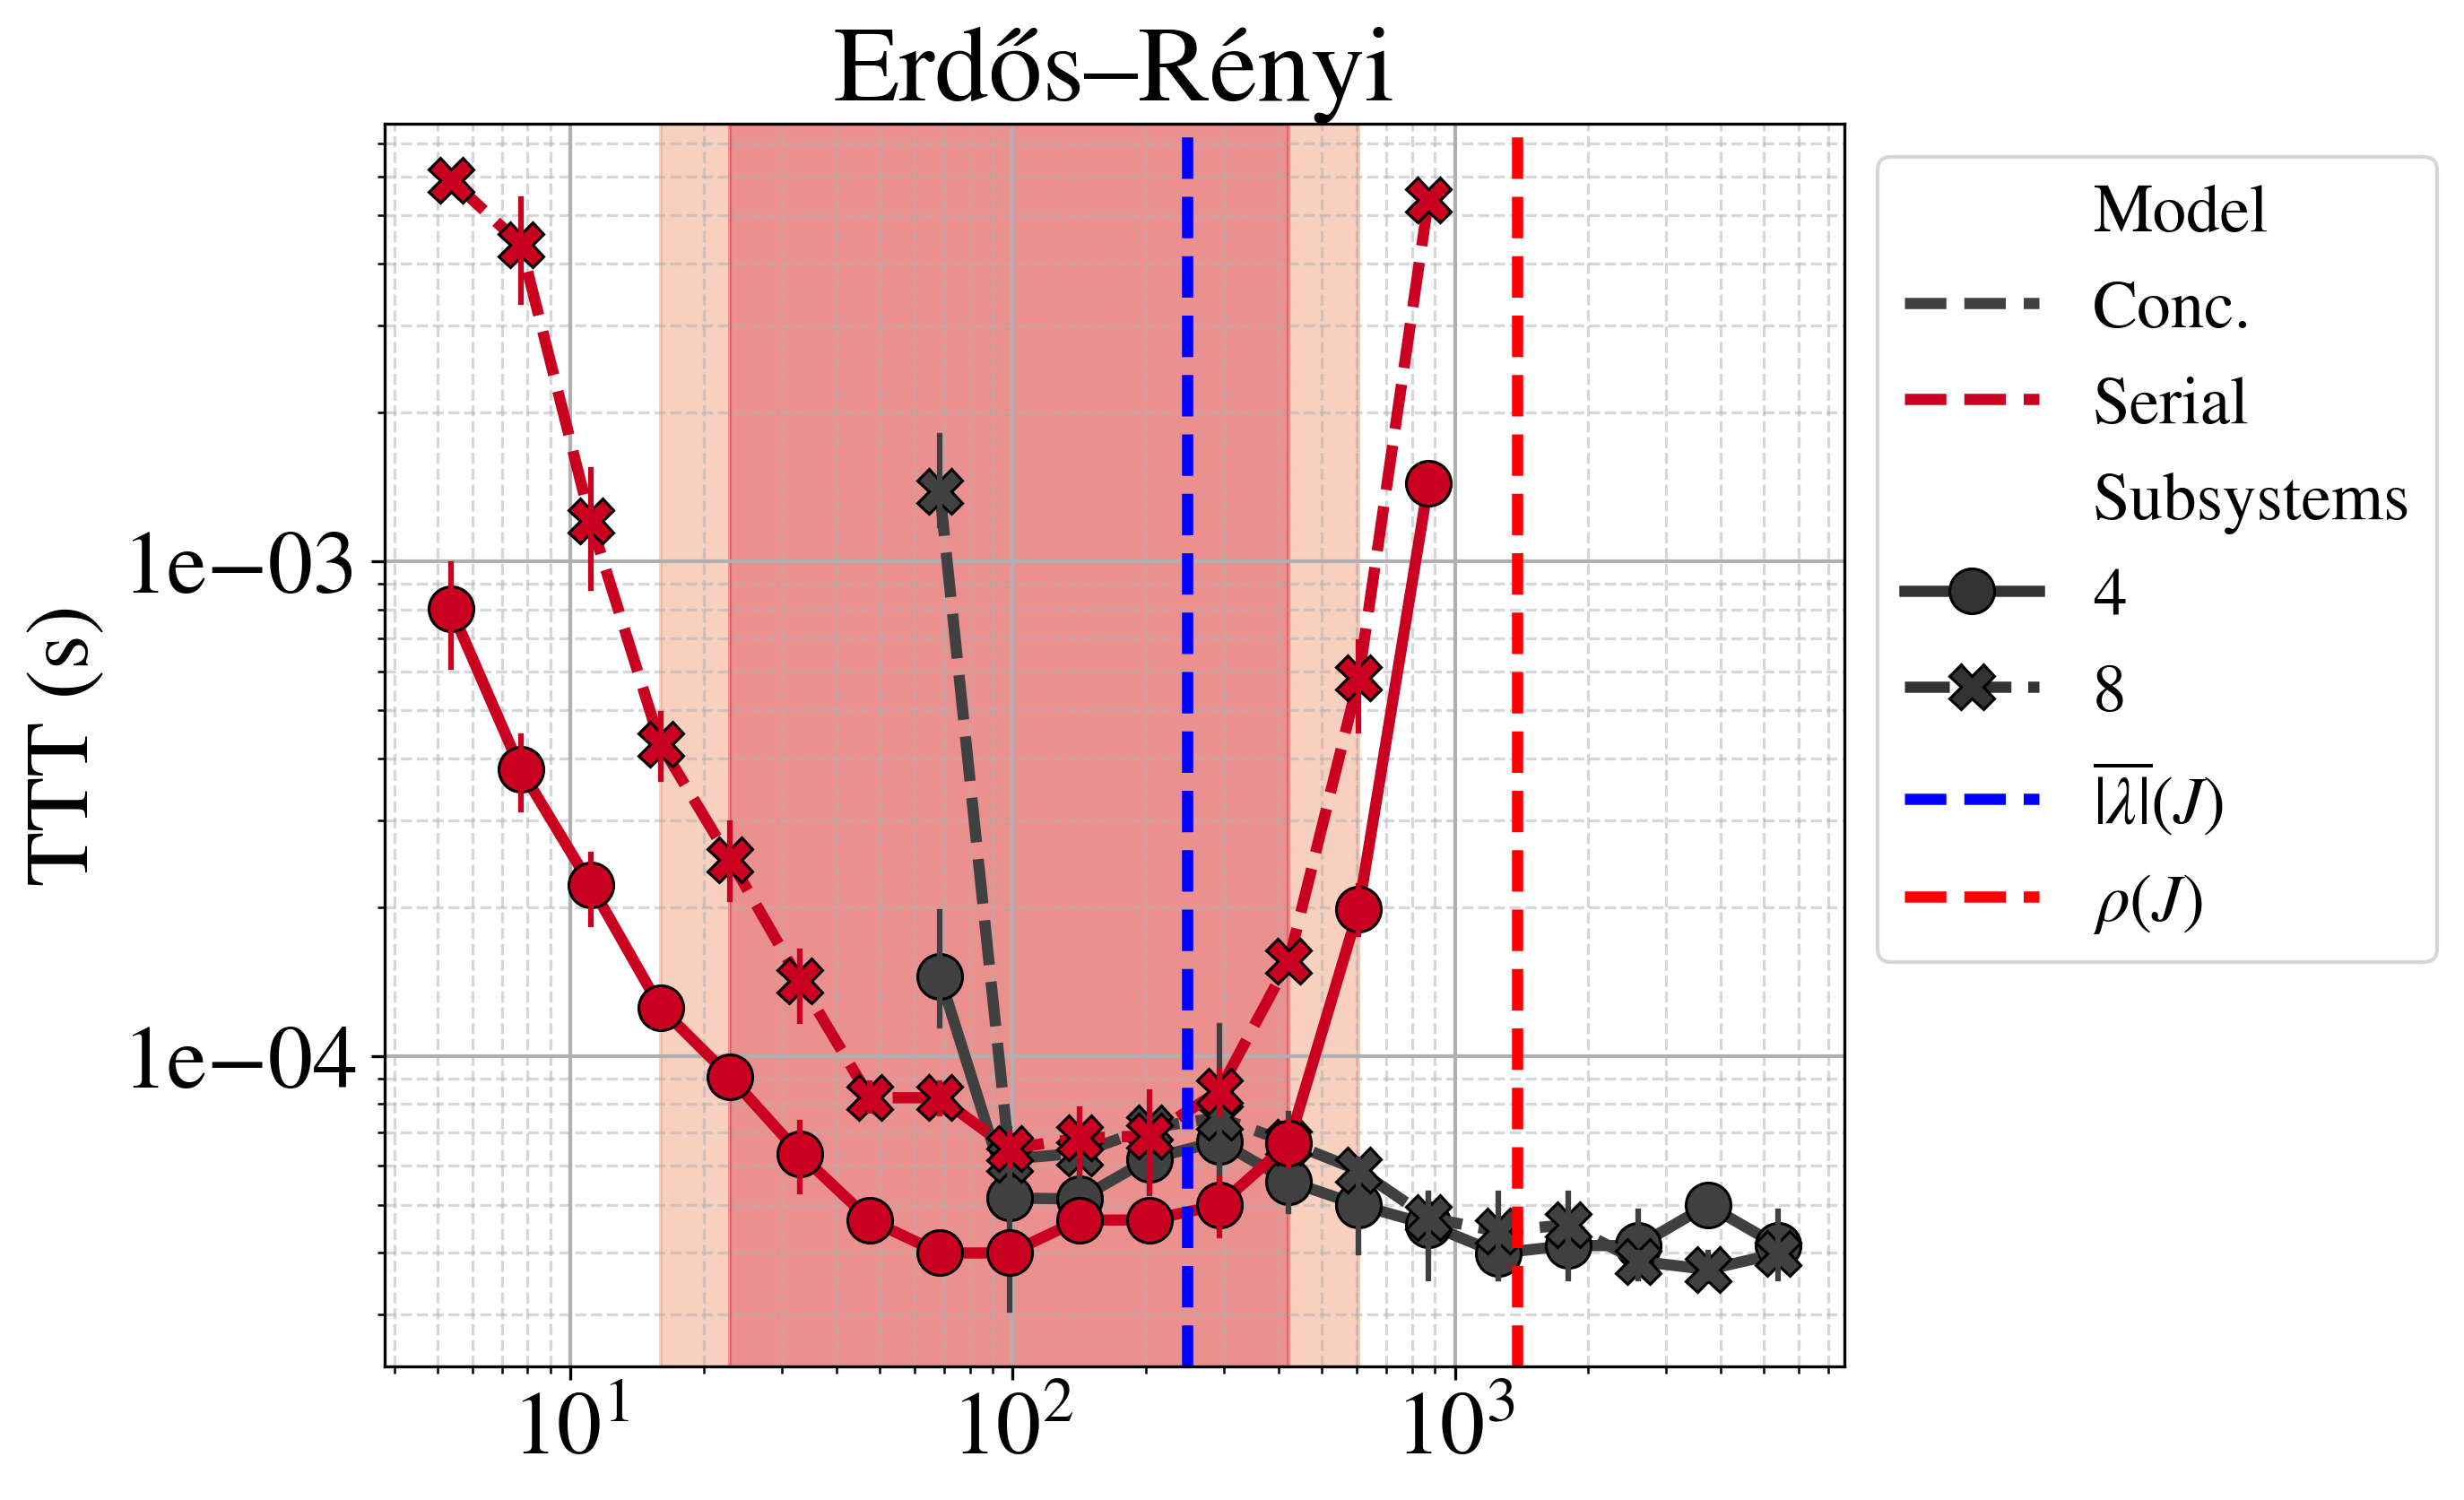

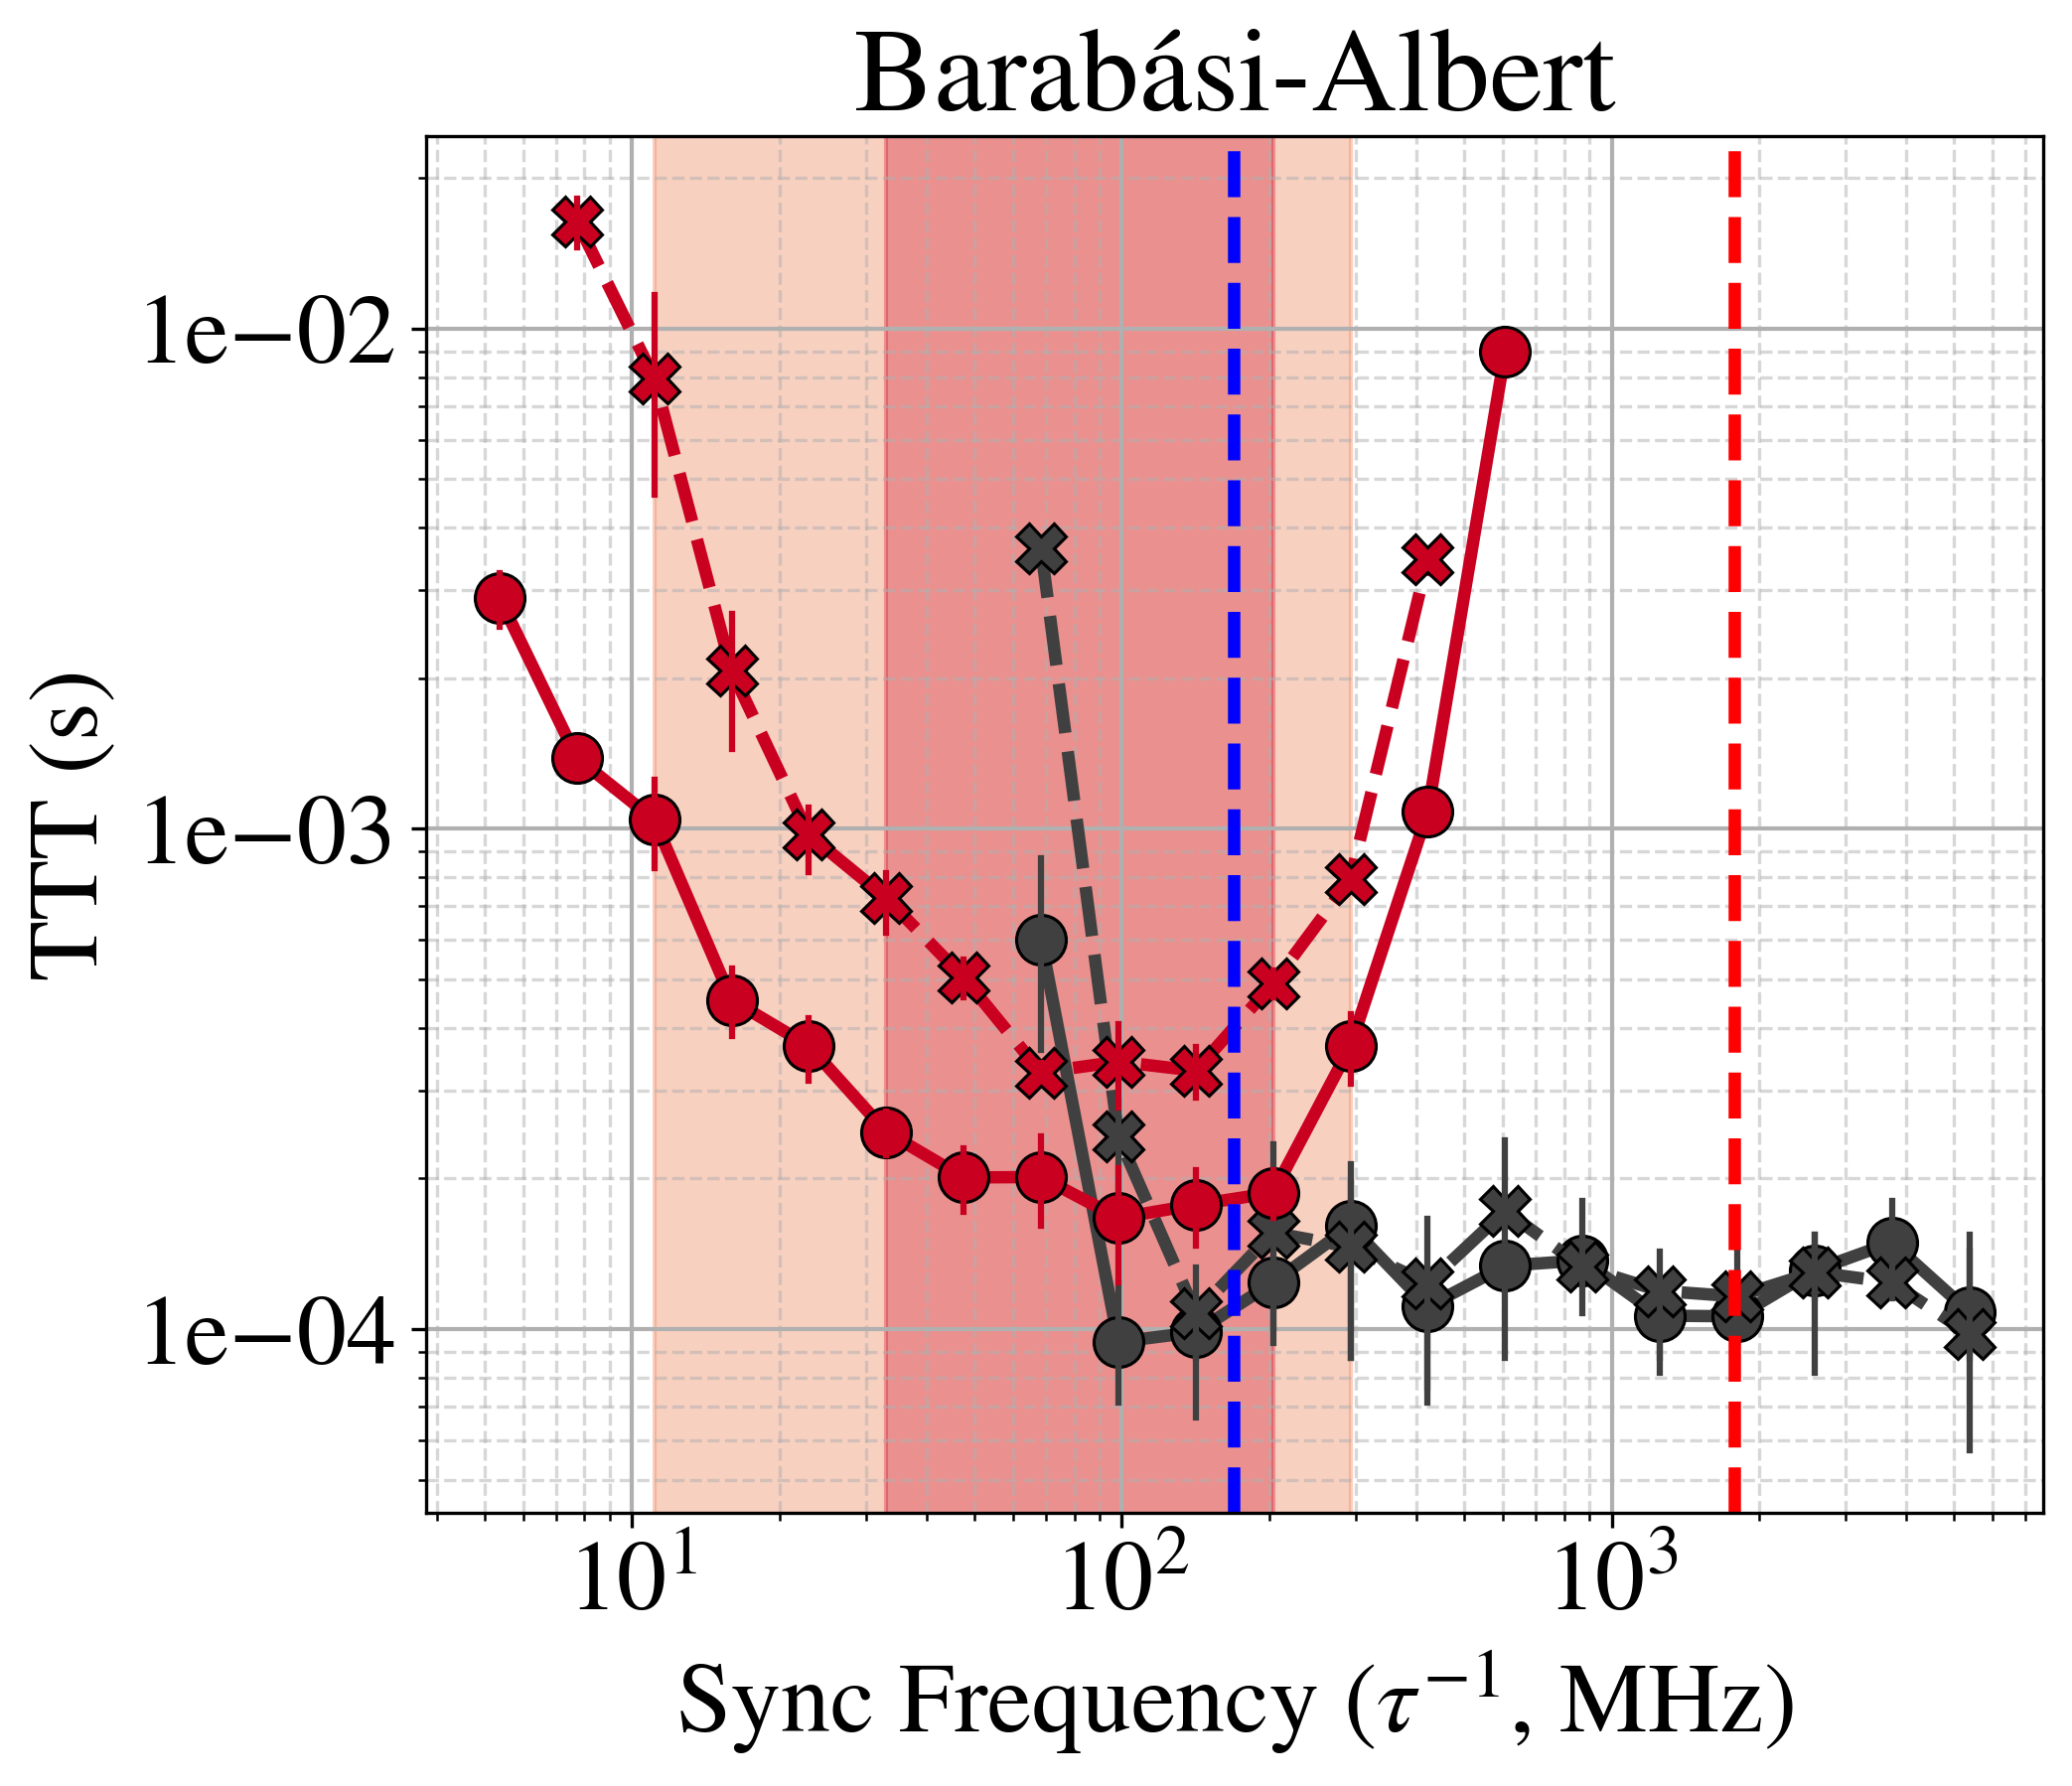

In [13]:
fig1, ax1 = plt.subplots(nrows=1, figsize=(7, 6))
fig2, ax2 = plt.subplots(nrows=1, figsize=(7, 6))#, gridspec_kw={'right': 0.4})
axs = [ax1, ax2]
brim_df_ttt = pd.concat([ pd.read_csv('../data/bw_vs_energy_ttt98.csv').query('concurrent == 1'), pd.read_csv('../data/bw_vs_energy_longer_ttt.csv')]).reset_index()
brim_df_ttt = brim_df_ttt.rename(columns={'blocks': 'Subsystems'})
# brim_df_ttt = pd.read_csv('../data/bw_vs_energy_ttt98.csv').rename(columns={'blocks': 'Subsystems'})
brim_df_ttt['Model'] = brim_df_ttt['concurrent'].replace({1.0: 'Conc.', 0.0: 'Serial'})
palette = [ "#404040",
            # "#fdb863",
            # "#f4a582",
            "#ca0020"
            ]
brim_df_ttt['Bandwidth'] = 1 / brim_df_ttt['tpart'] / 1e6
# brim_df_ttt['error'] = brim_df_ttt['u'] - -0.7633
line_args = dict(
    y='TTT',
    x='Bandwidth',
    linestyle='--',
    # marker='X',
    markers=True,
    markersize=12,
    style='Subsystems',
    linewidth=3,
    hue='Model',
    markeredgecolor='black',
    err_style='bars',
    palette=palette
)
brim_df_ttt = brim_df_ttt.sort_values(by=['Model', 'Subsystems'])
sns.lineplot(ax=axs[0],
                data=brim_df_ttt.query('GInd < 30'), 
                **line_args)
sns.lineplot(ax=axs[1],
                data=brim_df_ttt.query('GInd > 30'), 
                **line_args)

eig1 = (49e-15 * 31e4) / eig_df.query('type == "ER"')['eigmean'].mean()
axs[0].axvline(1/eig1 / 1e6, color='blue', linewidth=3, linestyle='--', label='$\\overline{|\\lambda|}(J)$')
eig2 = (49e-15 * 31e4) / eig_df.query('type == "BA"')['eigmean'].mean()
axs[1].axvline(1/eig2 / 1e6, color='blue', linewidth=3, linestyle='--')
eig1 = (49e-15 * 31e4) / eig_df.query('type == "ER"')['eigmax'].mean()
axs[0].axvline(1/eig1 / 1e6, color='red', linewidth=3, linestyle='--', label='$\\rho(J)$')
eig2 = (49e-15 * 31e4) / eig_df.query('type == "BA"')['eigmax'].mean()
axs[1].axvline(1/eig2 / 1e6, color='red', linewidth=3, linestyle='--')
axs[0].legend(fontsize=18, loc='upper left', bbox_to_anchor=(1,1))
axs[0].legend(fontsize=18, loc='upper left', bbox_to_anchor=(1,1))

axs[0].set_title('Erdős–Rényi')
axs[1].set_title('Barabási-Albert')
axs[0].set_xlabel('')
axs[1].set_xlabel('Sync Frequency ($\\tau^{-1}$, MHz)')

for ax in axs:
   ax.set_xscale('log')
   ax.set_yscale('log')
#    ax.set_xlabel('Sync Frequency ($\\tau^{-1}$, MHz)')
   ax.set_ylabel('TTT (s)')
   ax.grid(which='major')
axs[1].legend_ = None
for ax in axs:

    ax.grid(which='minor', linestyle='--', alpha=0.5)
    ax.grid(which='major', linewidth=1)
    ax.yaxis.set_major_locator(tk.LogLocator(base=10, subs=[1]))
    ax.yaxis.set_minor_locator(tk.LogLocator(base=10, subs=[1,2,3,4,5,6,7,8,9]))
    ax.xaxis.set_major_locator(tk.LogLocator(base=10, subs=[1]))
    ax.xaxis.set_minor_locator(tk.LogLocator(base=10, subs=[1,2,3,4,5,6,7,8,9]))
    # ax.yaxis.set_minor_locator(tk.FixedLocator([50, 150, 200]))
    ax.yaxis.set_major_formatter(tk.LogFormatter())
    # ax.yaxis.set_minor_formatter(tk.ScalarFormatter())

# axs[0].annotate(text="(a)", xy=(0.45, -0.15), xycoords='axes fraction', fontsize=28)

# axs[1].annotate(text="(b)", xy=(0.45, -0.3), xycoords='axes fraction', fontsize=28)
oldaxes = axs[0].get_ylim()
axs[0].fill_betweenx(y=[1e-8, 1],x1=lim_er4[('Bandwidth', 'min')], x2=lim_er4[('Bandwidth', 'max')], color='#ef8a62', alpha=0.4)
axs[0].fill_betweenx(y=[1e-8, 1],x1=lim_er8[('Bandwidth', 'min')], x2=lim_er8[('Bandwidth', 'max')], color='#ca0020', alpha=0.3)
axs[0].set_ylim(oldaxes)
            # "#ef8a62",
            # "#999999",

oldaxes = axs[1].get_ylim()
axs[1].fill_betweenx(y=[1e-8, 1],x1=lim_ba4[('Bandwidth', 'min')], x2=lim_ba4[('Bandwidth', 'max')], color="#ef8a62", alpha=0.4)
axs[1].fill_betweenx(y=[1e-8, 1],x1=lim_ba8[('Bandwidth', 'min')], x2=lim_ba8[('Bandwidth', 'max')], color="#ca0020", alpha=0.3)
axs[1].set_ylim(oldaxes)
plt.show()
fig.savefig('../figures/fig_9_ba_er_ttt.pdf', bbox_inches='tight')
fig1.savefig('../figures/fig_9a_ba_er_ttt.pdf', bbox_inches='tight')
fig2.savefig('../figures/fig_9b_ba_er_ttt.pdf', bbox_inches='tight')

In [87]:
lim_er[('Bandwidth', 'min')]

6    15.979165
Name: (Bandwidth, min), dtype: float64

In [10]:
brim_df.anneal.unique()

array([2.00000e-05, 4.00033e-05, 4.00131e-05, 4.00055e-05, 4.00034e-05,
       4.00006e-05, 4.00029e-05, 4.00208e-05, 6.00017e-05, 6.00011e-05,
       6.00160e-05, 8.00023e-05, 8.00259e-05, 8.00112e-05, 6.00086e-05,
       8.00008e-05, 6.00238e-05, 8.00526e-05, 1.00017e-04, 1.00004e-04,
       6.00123e-05, 6.00083e-05, 4.00009e-05, 8.00002e-05, 8.00012e-05,
       8.00067e-05, 6.00015e-05, 6.00033e-05, 6.00043e-05, 1.00001e-04,
       8.00313e-05, 8.00034e-05, 1.00006e-04, 1.00097e-04, 8.00261e-05,
       1.00043e-04, 1.00002e-04, 1.00029e-04, 1.00019e-04, 1.00097e-04,
       6.00843e-05, 4.00002e-05, 4.00008e-05, 6.00014e-05, 1.00000e-04,
       4.00004e-05, 6.00015e-05, 6.00017e-05, 8.00057e-05, 8.00115e-05,
       1.00011e-04, 1.00007e-04, 6.00000e-05, 6.00000e-05, 6.01665e-05,
       4.00489e-05, 6.00005e-05, 8.00005e-05, 6.00003e-05])

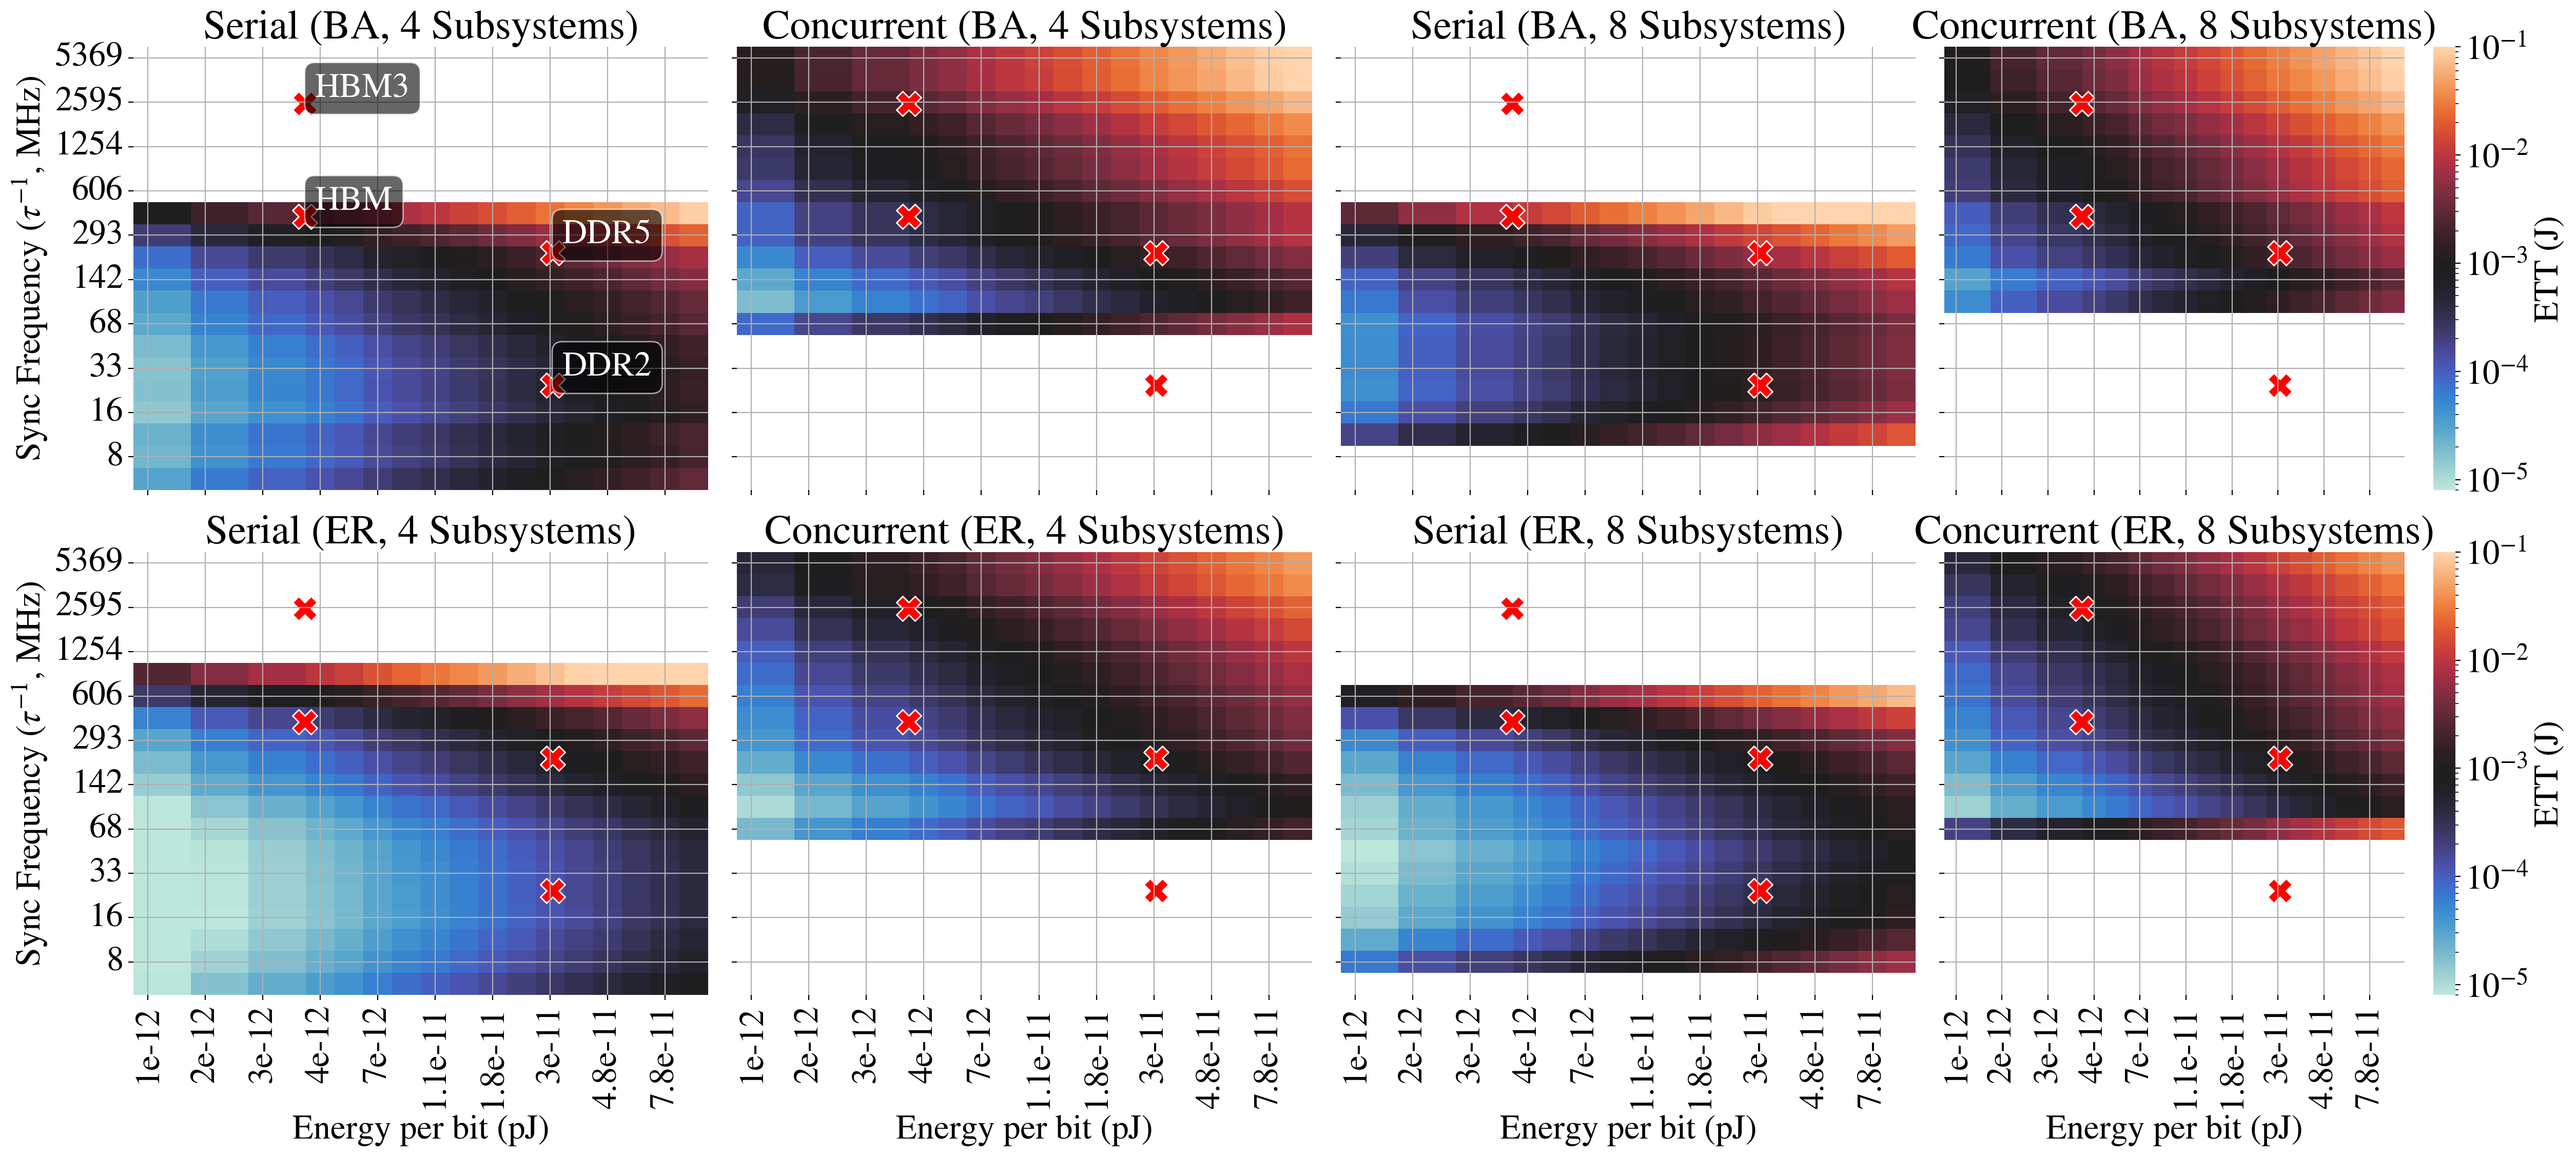

In [24]:
from matplotlib.colors import LogNorm
fig, axs = plt.subplots(ncols=4, nrows=2, dpi=200, figsize=(30, 12),
                        gridspec_kw={'wspace': 0.05, 'hspace': 0.14})
ind = 0

comp_y = np.logspace(-12, -10, 20).round(decimals=12)

for (((c,b,t), subdf), ax)  in zip(ttt_df.groupby(['Type', 'blocks', 'concurrent']), axs.flatten()):
    comp_bits = subdf.sort_values(by='tpart').groupby(['tpart']).mean(numeric_only=True).reset_index()
    bandwidth = np.round(np.round(1 / (comp_bits['tpart']) / 1e9, decimals=4) * 1e3).astype(int)
    comp_ene = np.outer(comp_bits['BTT'], comp_y)
    vals = pd.DataFrame(data=comp_ene, index=bandwidth, columns=comp_y)
    vals = vals.replace({np.inf: np.nan})
    if ind not in {3, 7}:
        sns.heatmap(ax=ax, data=vals, norm=LogNorm(vmin=8e-6, vmax=1e-1), cmap='icefire', 
                    cbar=False, zorder=-1)
    else:
        sns.heatmap(ax=ax, data=vals, norm=LogNorm(vmin=8e-6, vmax=1e-1), cmap='icefire',  
                    cbar_kws={'label': "ETT (J)"}, zorder=-1)
    if ind not in {0, 4}:
        ax.set_yticklabels(['' for _ in ax.get_yticks()])
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Sync Frequency ($\\tau^{-1}$, MHz)')
    if ind < 4:
        ax.set_xticklabels(['' for _ in ax.get_xticks()])
        ax.set_xlabel('')
    else:
        ax.set_xlabel('Energy per bit (pJ)')
    if t:
        ax.set_title('Concurrent ({}, {} Subsystems)'.format(c, b))
    else:
        ax.set_title('Serial ({}, {} Subsystems)'.format(c, b))
    ax.grid()
    yticks = ax.get_yticks()

    for bw, label in zip([6553.6, 1024], ['HBM3', 'HBM']):
        bw = bw / (1<<30) * 1e9
        hbmmax = bw / (2000) * 1e3
        ticks = ax.get_yticks()
        loc = 20-np.interp([np.log10(hbmmax)], np.log10(bandwidth)[::-1], np.arange(len(np.log10(bandwidth)[::-1])))

        locx = np.interp([np.log10(3.97e-12)], np.log10(comp_y), np.arange(20))
        ax.scatter(y=(loc), x=locx, linewidth=1, zorder=1, s=300, color='red', marker='X', edgecolor='w')
        if ind == 0:
            ax.annotate(xy=(locx[0], loc[0]), xytext=(7, 5), textcoords='offset points', text=label, color='white',bbox=dict(facecolor='k', alpha=0.6, edgecolor='white', boxstyle='round'))
    for bw, label in zip([563.2, 64], ['DDR5', 'DDR2']):
        bw = bw / (1<<30) * 1e9
        hbmmax = bw / (2000) * 1e3
        ticks = ax.get_yticks()
        loc = 20-np.interp([np.log10(hbmmax)], np.log10(bandwidth)[::-1], np.arange(len(np.log10(bandwidth)[::-1])))
        locx = np.interp([np.log10(34.42e-12)], np.log10(comp_y), np.arange(len(comp_y)))
        ax.scatter(y=(loc), x=locx, linewidth=1, zorder=1, s=300, color='red', marker='X', edgecolor='w')
        if ind == 0:
            ax.annotate(xy=(locx[0], loc[0]), xytext=(7, 7), textcoords='offset points', text=label, color='white', bbox=dict(facecolor='k', alpha=0.6, edgecolor='white', boxstyle='round'))
        
    ind+=1
fig.savefig('../figures/fig_10_pra_energy.pdf', bbox_inches='tight')
plt.show()